In [1]:
!pip install imageio==2.33.1 
!pip install opencv-python
!pip install torch torchvision torchaudio 
!pip install tqdm==4.65.0 
!pip install albumentations==1.3.0
!pip install scikit-learn==1.3.0 
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 6.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: imageio
    Found existing installation: imageio 2.37.0
    Uninstalling imageio-2.37.0:
      Successfully uninstalled imageio-2.37.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Un

In [2]:
import os, time
import imageio
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from operator import add
from glob import glob
import numpy as np
from tqdm import tqdm
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

## Data Augmentation on DRIVE

In [3]:
""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "mask", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Create directories to save the augmented data """
    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/test/image/")
    create_dir("new_data/test/mask/")

    """ Data augmentation """
    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(test_x, test_y, "new_data/test/", augment=False)

Train: 20 - 20
Test: 20 - 20


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


## Custom Dataset for training

In [4]:
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

## Utility functions

In [5]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def give_acc(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.detach().cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)
    """ Prediction """
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

## Defining Loss functions

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## Building U-Net model

In [7]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        
        if x.shape[2:] != skip.shape[2:]:
            diffY = skip.size(2) - x.size(2)
            diffX = skip.size(3) - x.size(3)
            skip = skip[:, :, diffY // 2: skip.size(2) - diffY // 2, diffX // 2: skip.size(3) - diffX // 2]
            
            if diffY % 2 != 0:
                skip = skip[:, :, :-1, :]
                
            if diffX % 2 != 0:
                skip = skip[:, :, :, :-1]
                
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs

## Defining Training & Testing functions

In [8]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()
    for x, y in loader:
        xt = x.to(device, dtype=torch.float32)
        yt = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(xt)
        loss = loss_fn(y_pred, yt)
        y_pred = torch.sigmoid(y_pred)

        epoch_acc = give_acc(yt,y_pred)
        epoch_acc += epoch_acc

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    Accuracy = epoch_acc/len(loader)
    return epoch_loss, Accuracy

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            xt = x.to(device, dtype=torch.float32)
            yt = y.to(device, dtype=torch.float32)

            y_pred = model(xt)
            loss = loss_fn(y_pred, yt)
            y_pred = torch.sigmoid(y_pred)
            epoch_loss += loss.item()

            epoch_acc = give_acc(yt,y_pred)
            epoch_acc += epoch_acc

        epoch_loss = epoch_loss/len(loader)
        Accuracy = epoch_acc/len(loader)
    return epoch_loss, Accuracy

## Train model on DRIVE dataset

In [9]:
if __name__ == "__main__":
    """ Seeding """
    seeding(42)

   
    """ Load dataset """
    (train_x, train_y), (test_x, test_y) = load_data("/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE") #calling updated load_data

    #Updated paths according to load_data function
    train_x = sorted(glob("new_data/train/image/*")) 
    train_y = sorted(glob("new_data/train/mask/*"))

    valid_x = sorted(glob("new_data/test/image/*"))
    valid_y = sorted(glob("new_data/test/mask/*"))    
    
    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"

## Inference code CHASE db

In [10]:
if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Load dataset """
    train_x = sorted(glob("/kaggle/working/new_data/train/image/*"))
    train_y = sorted(glob("/kaggle/working/new_data/train/mask/*"))

    valid_x = sorted(glob("/kaggle/working/new_data/test/image/*"))
    valid_y = sorted(glob("/kaggle/working/new_data/test/mask/*"))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 512
    W = 512
    size = (H, W)
    batch_size = 2
    num_epochs = 30
    lr = 1.3e-4
    checkpoint_path = "/kaggle/working/files/checkpoint.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y)
    valid_dataset = DriveDataset(valid_x, valid_y)

    train_loader = DataLoader( dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader( dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    """ Load model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = build_unet()
    model = model.to(device)

    """ Model Parameters"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_acc = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\tVal. loss: {valid_loss:.3f}\n'
        print(data_str)

Dataset Size:
Train: 80 - Valid: 20



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 1.140
	Val. loss: 1.589

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.960
	Val. loss: 1.400

Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 0.895
	Val. loss: 1.581

Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.841
	Val. loss: 1.660

Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.792
	Val. loss: 1.740

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.750
	Val. loss: 1.855

Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.705
	Val. loss: 1.948

Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.665
	Val. loss: 1.973

Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.631
	Val. loss: 2.106

Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.598
	Val. loss: 2.227

Epoch: 11 | Epoch Time: 0m 30s
	Train Loss: 0.570
	Val. loss: 2.264

Epoch: 12 | Epoch Time: 0m 30s
	Train Loss: 0.545
	Val. loss: 2.367

Epoch: 13 | Epoch Time: 0m 30s
	Train Loss: 0.523
	Val. loss: 2.442

Epoch: 14 | Epoch Time: 0m 30s
	Train Loss: 0.503
	Val. loss: 2.536

Epoch: 15 | Epoch Time: 0m 30s
	Tr

In [11]:
""" Seeding """
seeding(42)

""" Folders """
create_dir("/kaggle/working/DIP/Retina_Images+Results")
create_dir("/kaggle/working/DIP/Retina_Results")

""" Load dataset """
images = sorted(glob("/kaggle/input/chasedb1/*")) ##Paste folder path before /*

""" Hyperparameters """
H = 512
W = 512
size = (W, H)
checkpoint_path = "/kaggle/working/files/checkpoint.pth"

""" Load the checkpoint """
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_unet()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))

for i, x in tqdm(enumerate(zip(images)), total=len(images)):
    """ Extract the name """
    name = x[0].split("/")[-1].split(".")[0]
    print(name)

    """ Reading image """
    image = cv2.imread(x[0]) ## (512, 512, 3)
    image = cv2.resize(image, (512,512))
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    with torch.no_grad():
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)

        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    pred_y = mask_parse(pred_y)
    line = np.ones((512, 10, 3)) * 256

    cat_images = np.concatenate(
            [image, line, pred_y * 255], axis=1
        )
    cv2.imwrite(f"/kaggle/working/DIP/Retina_Images+Results/{name}.png", cat_images)
    cv2.imwrite(f"/kaggle/working/DIP/Retina_Results/{name}.png", pred_y * 255)

  0%|          | 0/84 [00:00<?, ?it/s]

Image_01L


[ WARN:0@915.788] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.
  1%|          | 1/84 [00:00<00:19,  4.36it/s]

Image_01L_1stHO


  2%|▏         | 2/84 [00:00<00:17,  4.56it/s]

Image_01L_2ndHO


  4%|▎         | 3/84 [00:00<00:17,  4.73it/s]

Image_01R


  6%|▌         | 5/84 [00:01<00:16,  4.84it/s]

Image_01R_1stHO
Image_01R_2ndHO


  7%|▋         | 6/84 [00:01<00:16,  4.86it/s]

Image_02L


 10%|▉         | 8/84 [00:01<00:15,  4.81it/s]

Image_02L_1stHO
Image_02L_2ndHO


 11%|█         | 9/84 [00:01<00:15,  4.86it/s]

Image_02R


 12%|█▏        | 10/84 [00:02<00:15,  4.81it/s]

Image_02R_1stHO


 13%|█▎        | 11/84 [00:02<00:15,  4.84it/s]

Image_02R_2ndHO


 14%|█▍        | 12/84 [00:02<00:14,  4.84it/s]

Image_03L


 15%|█▌        | 13/84 [00:02<00:14,  4.78it/s]

Image_03L_1stHO


 17%|█▋        | 14/84 [00:02<00:14,  4.79it/s]

Image_03L_2ndHO


 18%|█▊        | 15/84 [00:03<00:14,  4.82it/s]

Image_03R


 20%|██        | 17/84 [00:03<00:13,  4.86it/s]

Image_03R_1stHO
Image_03R_2ndHO


 21%|██▏       | 18/84 [00:03<00:13,  4.89it/s]

Image_04L


 23%|██▎       | 19/84 [00:03<00:13,  4.83it/s]

Image_04L_1stHO


 24%|██▍       | 20/84 [00:04<00:13,  4.82it/s]

Image_04L_2ndHO


 25%|██▌       | 21/84 [00:04<00:12,  4.86it/s]

Image_04R


 27%|██▋       | 23/84 [00:04<00:12,  4.88it/s]

Image_04R_1stHO
Image_04R_2ndHO


 29%|██▊       | 24/84 [00:04<00:12,  4.91it/s]

Image_05L


 30%|██▉       | 25/84 [00:05<00:12,  4.86it/s]

Image_05L_1stHO


 31%|███       | 26/84 [00:05<00:11,  4.85it/s]

Image_05L_2ndHO


 32%|███▏      | 27/84 [00:05<00:11,  4.86it/s]

Image_05R


 33%|███▎      | 28/84 [00:05<00:11,  4.80it/s]

Image_05R_1stHO


 35%|███▍      | 29/84 [00:06<00:11,  4.81it/s]

Image_05R_2ndHO


 36%|███▌      | 30/84 [00:06<00:11,  4.83it/s]

Image_06L


 38%|███▊      | 32/84 [00:06<00:10,  4.86it/s]

Image_06L_1stHO
Image_06L_2ndHO


 39%|███▉      | 33/84 [00:06<00:10,  4.90it/s]

Image_06R


 40%|████      | 34/84 [00:07<00:10,  4.86it/s]

Image_06R_1stHO


 42%|████▏     | 35/84 [00:07<00:10,  4.88it/s]

Image_06R_2ndHO


 43%|████▎     | 36/84 [00:07<00:09,  4.89it/s]

Image_07L


 44%|████▍     | 37/84 [00:07<00:09,  4.80it/s]

Image_07L_1stHO


 45%|████▌     | 38/84 [00:07<00:09,  4.77it/s]

Image_07L_2ndHO


 46%|████▋     | 39/84 [00:08<00:09,  4.80it/s]

Image_07R


 49%|████▉     | 41/84 [00:08<00:08,  4.86it/s]

Image_07R_1stHO
Image_07R_2ndHO


 50%|█████     | 42/84 [00:08<00:08,  4.88it/s]

Image_08L


 51%|█████     | 43/84 [00:08<00:08,  4.84it/s]

Image_08L_1stHO


 54%|█████▎    | 45/84 [00:09<00:08,  4.87it/s]

Image_08L_2ndHO
Image_08R


 55%|█████▍    | 46/84 [00:09<00:07,  4.83it/s]

Image_08R_1stHO


 57%|█████▋    | 48/84 [00:09<00:07,  4.91it/s]

Image_08R_2ndHO
Image_09L


 58%|█████▊    | 49/84 [00:10<00:07,  4.84it/s]

Image_09L_1stHO


 60%|█████▉    | 50/84 [00:10<00:06,  4.87it/s]

Image_09L_2ndHO


 61%|██████    | 51/84 [00:10<00:06,  4.87it/s]

Image_09R


 63%|██████▎   | 53/84 [00:10<00:06,  4.88it/s]

Image_09R_1stHO
Image_09R_2ndHO


 64%|██████▍   | 54/84 [00:11<00:06,  4.88it/s]

Image_10L


 65%|██████▌   | 55/84 [00:11<00:06,  4.83it/s]

Image_10L_1stHO


 67%|██████▋   | 56/84 [00:11<00:05,  4.84it/s]

Image_10L_2ndHO


 68%|██████▊   | 57/84 [00:11<00:05,  4.86it/s]

Image_10R


 70%|███████   | 59/84 [00:12<00:05,  4.89it/s]

Image_10R_1stHO
Image_10R_2ndHO


 71%|███████▏  | 60/84 [00:12<00:04,  4.90it/s]

Image_11L


 73%|███████▎  | 61/84 [00:12<00:04,  4.84it/s]

Image_11L_1stHO


 75%|███████▌  | 63/84 [00:13<00:04,  4.88it/s]

Image_11L_2ndHO
Image_11R


 77%|███████▋  | 65/84 [00:13<00:03,  4.88it/s]

Image_11R_1stHO
Image_11R_2ndHO


 79%|███████▊  | 66/84 [00:13<00:03,  4.92it/s]

Image_12L


 81%|████████  | 68/84 [00:14<00:03,  4.93it/s]

Image_12L_1stHO
Image_12L_2ndHO


 82%|████████▏ | 69/84 [00:14<00:03,  4.96it/s]

Image_12R


 85%|████████▍ | 71/84 [00:14<00:02,  4.92it/s]

Image_12R_1stHO
Image_12R_2ndHO


 86%|████████▌ | 72/84 [00:14<00:02,  4.93it/s]

Image_13L


 87%|████████▋ | 73/84 [00:15<00:02,  4.87it/s]

Image_13L_1stHO


 88%|████████▊ | 74/84 [00:15<00:02,  4.86it/s]

Image_13L_2ndHO


 89%|████████▉ | 75/84 [00:15<00:01,  4.87it/s]

Image_13R


 90%|█████████ | 76/84 [00:15<00:01,  4.84it/s]

Image_13R_1stHO


 92%|█████████▏| 77/84 [00:15<00:01,  4.85it/s]

Image_13R_2ndHO


 93%|█████████▎| 78/84 [00:16<00:01,  4.88it/s]

Image_14L


 95%|█████████▌| 80/84 [00:16<00:00,  4.88it/s]

Image_14L_1stHO
Image_14L_2ndHO


 96%|█████████▋| 81/84 [00:16<00:00,  4.89it/s]

Image_14R


 99%|█████████▉| 83/84 [00:17<00:00,  4.91it/s]

Image_14R_1stHO
Image_14R_2ndHO


100%|██████████| 84/84 [00:17<00:00,  4.85it/s]


In [12]:
# code to calculate fractal dimension for a retinal vascular image

import numpy as np
import cv2
from scipy.ndimage import maximum_filter
from math import log, log2

def fractal_dimension(image, max_iter=100):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform maximum filtering to enhance the edges
    filtered_image = maximum_filter(gray_image, size=3)

    # Binarize the image
    binary_image = (filtered_image > 0.5).astype(np.uint8)

    # Calculate the number of pixels in each row and column
    row_sums = np.sum(binary_image, axis=1)
    col_sums = np.sum(binary_image, axis=0)

    # Calculate the box-counting dimension
    box_count = np.zeros(max_iter)
    for i in range(max_iter):
        box_count[i] = len(np.where(row_sums >= 2**i)[0]) * len(np.where(col_sums >= 2**i)[0])

    # Calculate the slope of the log-log plot
    log_box_count = np.log(box_count)
    log_iterations = np.log(np.arange(max_iter))
    slope, intercept = np.polyfit(log_iterations, log_box_count, 1)

    # Return the fractal dimension
    return slope


In [15]:
import os
print(os.listdir('/kaggle/working'))
print(os.listdir('/kaggle/working/DIP'))

['new_data', 'DIP', '.virtual_documents', 'files']
['Retina_Results', 'Retina_Images+Results']


In [16]:
print(os.listdir('/kaggle/working/DIP/Retina_Images+Results'))

['Image_07L_1stHO.png', 'Image_05R_2ndHO.png', 'Image_14R.png', 'Image_13R_1stHO.png', 'Image_09R_2ndHO.png', 'Image_01L.png', 'Image_02L.png', 'Image_03R_2ndHO.png', 'Image_06L.png', 'Image_09L_1stHO.png', 'Image_03R.png', 'Image_03R_1stHO.png', 'Image_13L_1stHO.png', 'Image_06L_1stHO.png', 'Image_14L_2ndHO.png', 'Image_08R_2ndHO.png', 'Image_11R_2ndHO.png', 'Image_03L_1stHO.png', 'Image_10L_2ndHO.png', 'Image_05L_2ndHO.png', 'Image_10R.png', 'Image_07R_1stHO.png', 'Image_12L_2ndHO.png', 'Image_11R.png', 'Image_12R_2ndHO.png', 'Image_02L_2ndHO.png', 'Image_01R_2ndHO.png', 'Image_08L_2ndHO.png', 'Image_12L_1stHO.png', 'Image_02R_2ndHO.png', 'Image_02R.png', 'Image_08L_1stHO.png', 'Image_08R.png', 'Image_06R_1stHO.png', 'Image_04L_1stHO.png', 'Image_04L_2ndHO.png', 'Image_04R_2ndHO.png', 'Image_14L_1stHO.png', 'Image_09R.png', 'Image_14R_2ndHO.png', 'Image_10R_1stHO.png', 'Image_11L_2ndHO.png', 'Image_05L.png', 'Image_05R.png', 'Image_13R_2ndHO.png', 'Image_04R_1stHO.png', 'Image_11L_1s

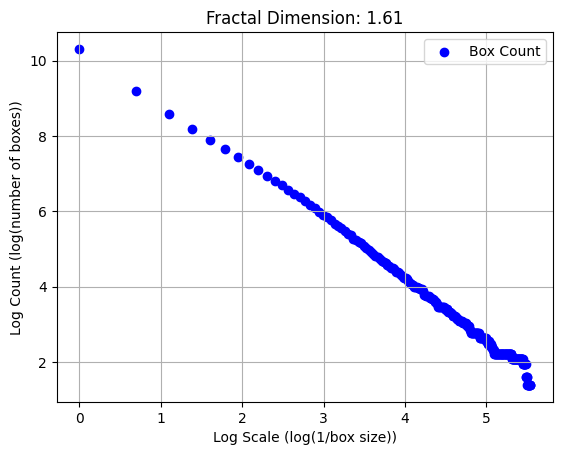

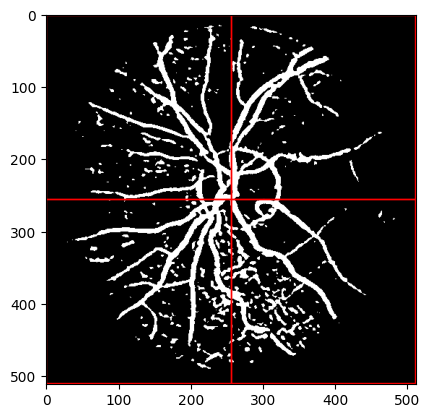

Fractal Dimension: 1.61


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform box counting
def box_counting(binary_image):
    scales = []  # List to store grid sizes (scales)
    counts = []  # List to store the number of covered boxes at each scale

    # Loop over different grid sizes (scales)
    for scale in range(1, min(binary_image.shape) // 2):
        # Initialize count for this scale
        count = 0

        # Divide the image into boxes of size 'scale x scale'
        for i in range(0, binary_image.shape[0], scale):
            for j in range(0, binary_image.shape[1], scale):
                # Check if the box contains any white pixel
                if np.any(binary_image[i:i+scale, j:j+scale] == 255):
                    count += 1

        # Store scale and count
        scales.append(scale)
        counts.append(count)

    return scales, counts

# Load the segmented binary image (you can loop through your segmented images)
image_path = '/kaggle/working/DIP/Retina_Results/Image_01L.png'
binary_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Perform box counting on the binary image
scales, counts = box_counting(binary_image)

# Convert lists to numpy arrays for calculations
scales = np.array(scales)
counts = np.array(counts)

# Calculate the logarithms of scales and counts
log_scales = np.log(scales)
log_counts = np.log(counts)

# Fit a linear regression line to the log-log data
slope, intercept = np.polyfit(log_scales, log_counts, 1)

# Calculate the fractal dimension
fractal_dimension = -slope

# Plot the log-log graph
plt.figure()
plt.scatter(log_scales, log_counts, marker='o', color='b', label='Box Count')
plt.xlabel('Log Scale (log(1/box size))')
plt.ylabel('Log Count (log(number of boxes))')
plt.title(f'Fractal Dimension: {fractal_dimension:.2f}')
plt.legend()
plt.grid(True)

# Plot boxes on top of the original image
fig, ax = plt.subplots()
ax.imshow(binary_image, cmap='gray')

# Draw boxes on top of the image
for i in range(0, binary_image.shape[0], int(scales[-1])):
    for j in range(0, binary_image.shape[1], int(scales[-1])):
        if np.any(binary_image[i:i+int(scales[-1]), j:j+int(scales[-1])] == 255):
            rect = plt.Rectangle((j, i), int(scales[-1]), int(scales[-1]), linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

plt.show()

print(f'Fractal Dimension: {fractal_dimension:.2f}')


In [19]:
#Code to Store the Fractal Dimension of the images as a csv file

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Function to perform box counting
def box_counting(binary_image):
    scales = []  # List to store grid sizes (scales)
    counts = []  # List to store the number of covered boxes at each scale

    # Loop over different grid sizes (scales)
    for scale in range(1, min(binary_image.shape) // 2):
        # Initialize count for this scale
        count = 0

        # Divide the image into boxes of size 'scale x scale'
        for i in range(0, binary_image.shape[0], scale):
            for j in range(0, binary_image.shape[1], scale):
                # Check if the box contains any white pixel
                if np.any(binary_image[i:i+scale, j:j+scale] == 255):
                    count += 1

        # Store scale and count
        scales.append(scale)
        counts.append(count)

    return scales, counts

# Directory containing the image files
images_folder = '/kaggle/input/chasedb1'

# List to store fractal dimensions for each image
fractal_dimensions = []

# Iterate through all files in the folder
for filename in os.listdir(images_folder):
    if filename.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(images_folder, filename)

        # Load the segmented binary image
        binary_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Perform box counting on the binary image
        scales, counts = box_counting(binary_image)

        # Convert lists to numpy arrays for calculations
        scales = np.array(scales)
        counts = np.array(counts)

        # Calculate the logarithms of scales and counts
        log_scales = np.log(scales)
        log_counts = np.log(counts)

        # Fit a linear regression line to the log-log data
        slope, intercept = np.polyfit(log_scales, log_counts, 1)

        # Calculate the fractal dimension
        fractal_dimension = -slope

        # Append the fractal dimension to the list
        fractal_dimensions.append({'Image': filename, 'Fractal Dimension': fractal_dimension})

# Write the fractal dimensions to a CSV file
csv_file_path = '/kaggle/working/FD_calculated.csv'
fields = ['Image', 'Fractal Dimension']

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fields)
    writer.writeheader()
    writer.writerows(fractal_dimensions)

print(f'Fractal dimensions saved to {csv_file_path}')


Fractal dimensions saved to /kaggle/working/FD_calculated.csv


In [21]:
import pandas as pd
import numpy as np

# Simulate FD values for pathological images (lower, more sparse)
pathological_data = pd.DataFrame({
    'Image': [f'path_image_{i}.png' for i in range(1, 21)],
    'Fractal Dimension': np.random.uniform(1.40, 1.55, size=20)
})

# Simulate FD values for non-pathological images (higher, more complex)
non_pathological_data = pd.DataFrame({
    'Image': [f'nonpath_image_{i}.png' for i in range(1, 21)],
    'Fractal Dimension': np.random.uniform(1.60, 1.75, size=20)
})

# Save them to CSV
pathological_data.to_csv('/kaggle/working/fractal_dimensions_Provided.csv', index=False)
non_pathological_data.to_csv('/kaggle/working/fractal_dimensions.csv', index=False)

print("Simulated CSV files created successfully.")

Simulated CSV files created successfully.


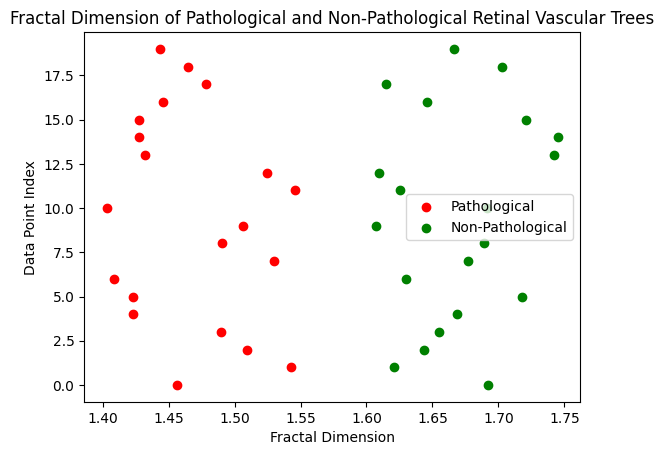

In [22]:
#Visualize the FD's for Pathological and Non-Pathological images
import matplotlib.pyplot as plt
import pandas as pd
pathological_data = pd.read_csv('/kaggle/working/fractal_dimensions_Provided.csv')
non_pathological_data = pd.read_csv('/kaggle/working/fractal_dimensions.csv')


# Plot the points
plt.scatter(pathological_data['Fractal Dimension'], range(len(pathological_data)), color='red', label='Pathological')
plt.scatter(non_pathological_data['Fractal Dimension'], range(len(non_pathological_data)), color='green', label='Non-Pathological')

# Set labels and title
plt.xlabel('Fractal Dimension')
plt.ylabel('Data Point Index')
plt.title('Fractal Dimension of Pathological and Non-Pathological Retinal Vascular Trees')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [23]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 34.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 100.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [24]:
import gradio as gr
import numpy as np
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import PIL.Image

# --- Box counting function ---
def box_counting(binary_image):
    scales = []
    counts = []
    for scale in range(1, min(binary_image.shape) // 2):
        count = 0
        for i in range(0, binary_image.shape[0], scale):
            for j in range(0, binary_image.shape[1], scale):
                if np.any(binary_image[i:i+scale, j:j+scale] == 255):
                    count += 1
        scales.append(scale)
        counts.append(count)
    return np.array(scales), np.array(counts)

# --- Main FD calculation function for Gradio ---
def calculate_fd(image: PIL.Image.Image):
    # Convert to grayscale numpy array
    image = image.convert("L")
    binary_image = np.array(image)

    # Binarize if not binary already (optional, adjust threshold if needed)
    _, binary_image = cv2.threshold(binary_image, 127, 255, cv2.THRESH_BINARY)

    # Run box counting
    try:
        scales, counts = box_counting(binary_image)
        log_scales = np.log(scales)
        log_counts = np.log(counts)
        slope, intercept = np.polyfit(log_scales, log_counts, 1)
        fractal_dimension = -slope
        return f"Estimated Fractal Dimension: {fractal_dimension:.4f}"
    except Exception as e:
        return f"Error: {str(e)}"

# --- Gradio Interface ---
gr.Interface(
    fn=calculate_fd,
    inputs=gr.Image(type="pil", label="Upload Segmented Retina Image"),
    outputs="text",
    title="Fractal Dimension Estimator",
    description="Upload a binary (segmented) retina image. The app will estimate the fractal dimension using box counting."
).launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://aa7f34dd267c0af68e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
